<h1>Machine Learning Project 1 - PLA</h1>
<p>Joshua John and Liora Wachsstock</p>

We generated points using the random.randint() python library, which has a random uniform discrete distribution. We assigned a positive value to the point if it was above the y = x line, and a negative value if it was below it. If the data was to be non-linearly separable, then around 10% of the time we switched the point's value.

Special things we did: we kept the best weights (determined by loss) during the svm learning. Similarly to the pocket algorithm from the PLA.

<h2> Useful Functions

<h4>Generate Data</h4>

In [1]:
import random
import time

random.seed(time.time())

def generate_data(size, linearly_separable=True, min_dist_btwn_points=0):
    data = [[0 for x in range(2)] for y in range(size)] 

    num_pos, num_neg = 0, 0
    
    for i in range(size):

        # Create random data point
        data[i][0] = random.randint(1,100)
        data[i][1] = random.randint(1,100)
        
        # Create optional distance between classes
        while(abs(data[i][0] - data[i][1]) <= min_dist_btwn_points):
            data[i][0] = random.randint(1,100)
            data[i][1] = random.randint(1,100)
            
        # Make sure there are equal amounts in each class
        while(num_pos >= (size / 2) and data[i][0] < data[i][1]):
            data[i][0] = random.randint(1,100)
            data[i][1] = random.randint(1,100) 
        while(num_neg >= (size / 2) and data[i][0] >= data[i][1]):
            data[i][0] = random.randint(1,100)
            data[i][1] = random.randint(1,100)
            
        # Point's position relative to x = y line determines value        
        if (data[i][0] < data[i][1]):
            data[i].append(1)
            num_pos += 1
        else:
            data[i].append(-1)
            num_neg += 1

        # Create non-linearly separable data by switching up the value 10% of the time
        # as long as a class is not full
        if (not linearly_separable and random.randint(1,10) % 10 == 0 and num_pos < (size / 2) and num_neg < (size / 2)):
            data[i][2] *= -1
            num_pos = num_pos + (1 if data[i][2] == 1 else -1)
            num_neg = num_neg + (1 if data[i][2] == -1 else -1)
            
    return data

<h4>Get the number of misclassifed points</h4>

In [2]:
import numpy as np
def num_missclassified_points(w, x, y):
    missed_points = []
    signs = np.sign(np.dot(x,w)) 
    for i in range(len(x)):
        if signs[i] != y[i]:
            missed_points.append(i)
    return len(missed_points)

<h4>loss function</h4>

In [3]:
import numpy as np
# calculate the loss of the weights
def get_loss(W, x, y, C):
    return 1/2 * np.sum(W**2) + C * np.sum([np.max([0, 1 - y[i] * (np.dot(W,x[i]))]) for i in range(len(x))])

# calculate the gradient of the loss
def lossGradient(W, x, y, C):
    lossGrad = np.zeros_like(W)
    distance = np.max([0, 1 - y * (np.dot(W,x))])
    
    if distance == 0:
        lossGrad = W
    else:
        lossGrad = W - np.multiply(np.multiply(x,y), C)
    
    return lossGrad

# svm algorithm using stochastic gradient decent 
def svm_sgd(X, Y, W, N_steps, lr, C): 
    low_loss = -1
    loss_over_time = []
    best_W = W
    best_checkpoint = 0
    
    update_counter = 0;
    for step in range(N_steps):
        point = np.random.randint(len(X)) # get a random index from the input array
        W = W - (lr * lossGradient(W, X[point], Y[point], C)) # update the weights based off the gradient of that array
        loss = get_loss(W,X,Y,C)
        update_counter += 1
        
        loss_over_time.append(loss) #for plotting at the end
        if loss < low_loss or low_loss == -1:
            best_checkpoint = update_counter
            low_loss = loss
            best_W = w
            
    return [W, best_checkpoint, N_steps, loss_over_time]

<h4>Order Data Function</h4>

In [4]:
def order(data):
    ordered_data = []
    for i in range(len(data)):
        if data[i][2] > 0:
            ordered_data.append(data[i])
            
    for i in range(len(data)):
        if data[i][2] <= 0:
            ordered_data.append(data[i])
            
    return ordered_data

<h4>Separate Data</h4>

In [5]:
def sep_data(data):
    #separate the points from values
    values, points = [],[]
    for i in range(len(data)):
        values.append(data[i][2])
        points.append([1, data[i][0], data[i][1]])  #using a dummy variable 1 for x0 (ie use w*x_aug) instead of b + w*x
    
    return [points, values]

<h4>Plot and Print Data</h4>

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def accuracy(weights, data):
    points, values = sep_data(data)
    return (float(num_missclassified_points(weights, points, values)) / len(data)) * 100

def line_string(weights):
    return 'y = ('+ str(-weights[0]) + ' + ' + str(-weights[1]) + 'x)/' + str(weights[2])

def print_stats(train_ls, test_ls, weights, lr, final_weights, C, total_updates, iterations, train_accuracy, test_accuracy):
    print('Note. We generated the points using the python library random.randint() for both x and y coordinates,')
    print('   which has a random uniform distribution. We then assigned a value based on the points position relative')
    print('   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.')
    print('    (https://docs.python.org/3/library/random.html)')
    print('1. Linearly separable training data :', train_ls)
    print('2. Linearly separable test data:', test_ls)
    print('3. Initial learning weights:', weights, ', learing rate:', lr, ', and C constant:', C)
    print('4.', line_string(final_weights))
    print('5. Total times the weights were updated:', total_updates)
    print('6. Final missclassification error on training data: ' + str(train_accuracy) + '%')
    print('   Final missclassification error on test data: '+ str(test_accuracy) + '%')
    print('7. the margin width is:', 2 / np.sqrt(sum(w**2)))
    

def print_conclusions(base_case, case_I, case_II, case_III):
    print("Base case used w = [0,0,0], step_size constant = 1, and points were kept in their random order.")
    print("The resulting line was", line_string(base_case))
    print('')
    print("I. w = [1,2,3], step_size = 1, and the points were kept in their random order:") 
    print("   Resulting line:", line_string(case_I))
    print("   Compared to base case result:", line_string(base_case))
    print('')
    print("II. w = [0,0,0], step_size = 2, and the points were kept in their random order:") 
    print("   Resulting line:", line_string(case_II))
    print("   Compared to base case result:", line_string(base_case))
    print('')
    print("III. w = [0,0,0], step_size = 1, and the points were grouped according to class (PLA dealt with one and then the other):") 
    print("   Resulting line:", line_string(case_III))
    print("   Compared to base case result:", line_string(base_case))
    

def plot_data(data, graph_title, weights=[], margins = False):
    df = pd.DataFrame(data, columns=("X", "Y", "value"))
    df.plot.scatter(x="X", y="Y", c="value", cmap='viridis', title=graph_title)

    x = np.array(range(100))
    
    #actual classifying line
    y = ((-weights[0]) - weights[1]*x) / weights[2]
    plt.plot(x, y)
    
    if (margins):
        #top margin line
        y1 = (((-weights[0]) - (weights[1]*x) + 1) / weights[2])
        plt.plot(x, y1)
    
        #bottom margin line
        y2 = (((-weights[0]) - (weights[1]*x) - 1) / weights[2])
        plt.plot(x, y2)

<h3><u> Generate Test Data:</u></h3>

In [7]:
test_data = generate_data(30, False, 10)
test_points, test_values = sep_data(test_data)

<h2><u>Linearly Separable Data Set</u></h2>

<h3>Generate Training Data:

In [8]:
tr_data_ls = generate_data(50, min_dist_btwn_points=20)

#serperate data
tr_points, tr_values = sep_data(tr_data_ls)

<h4>Base case (w = [0,0,0], step_size = 1, ordered = false):

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0005 , and C constant: 1
4. y = (0.00041638473135096926 + 0.0975234516782086x)/0.10299224558092399
5. Total times the weights were updated: 400
6. Final missclassification error on training data: 0.0%
   Final missclassification error on test data: 3.3333333333333335%
7. the margin width is: 14.100459973199426


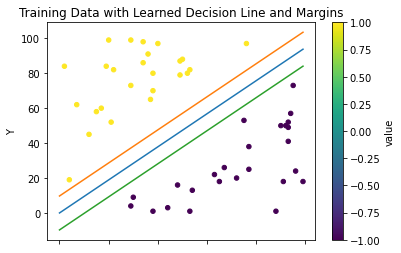

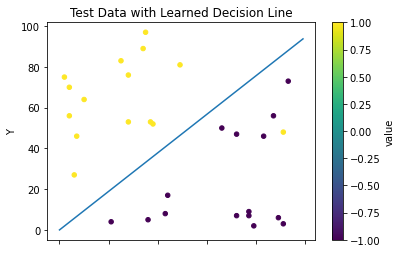

In [9]:
#Variables
steps = 400
learning_rate = 0.0005
C = 1;
w = np.array([0,0,0])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points, tr_values, w, steps, learning_rate, C)

plot_data(tr_data_ls, 'Training Data with Learned Decision Line and Margins', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls), accuracy(w, test_data))

#save result
base_case = w

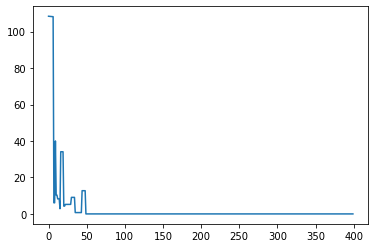

In [10]:
y = loss_array
x = np.array(range(len(y)))
plt.plot(x, y)

<h4>Case I. where w = [1,1,1] step_size = 0.0001, ordered = false, C = 1

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 1
4. y = (-0.9428921688341124 + 0.2840030956221944x)/0.48488611743667615
5. Total times the weights were updated: 400
6. Final missclassification error on training data: 6.0%
   Final missclassification error on test data: 16.666666666666664%
7. the margin width is: 1.8220877214200049


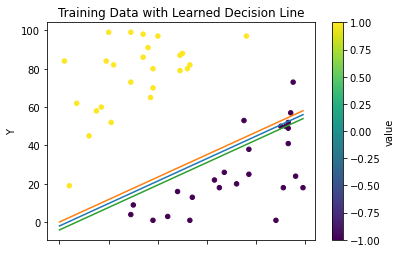

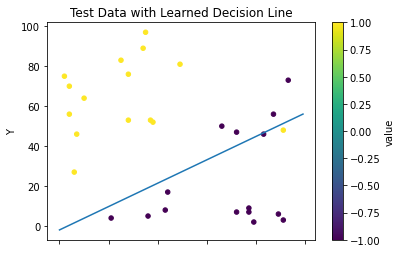

In [11]:
#Variables
steps = 400
learning_rate = 0.0001
C = 1;
w = np.array([1,1,1])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points, tr_values, w, steps, learning_rate, C)

plot_data(tr_data_ls, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls), accuracy(w, test_data))

Changing the initial weights, tends to changes the orientation of the line generated as well as the margin size. likely this happens because the learning model here would need adjustments in more steps and constants

<h4>Case II. where w = [0,0,0] step_size = 0.1, ordered = false, C = 1

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.1 , and C constant: 1
4. y = (-0.024275557588757622 + 1.9342727897001393x)/4.1845985924901
5. Total times the weights were updated: 272
6. Final missclassification error on training data: 16.0%
   Final missclassification error on test data: 16.666666666666664%
7. the margin width is: 0.4338316619976099


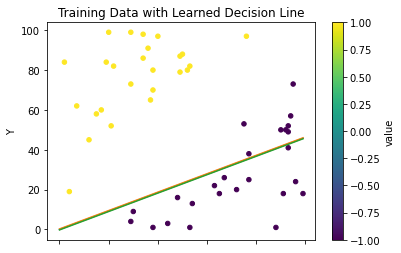

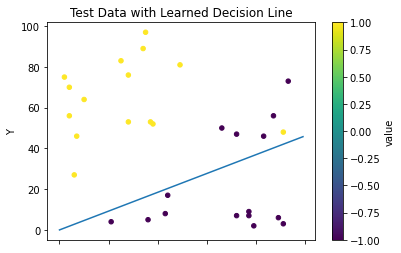

In [12]:
#Variables
steps = 400
learning_rate = 0.1
C = 1;
w = np.array([0,0,0])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points, tr_values, w, steps, learning_rate, C)

plot_data(tr_data_ls, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls), accuracy(w, test_data))

increasing the learning rate creates an uncenterd line and very small margins. likely due to too big of adjustments to the weights

<h4>Case III. where w = [0,0,0] step_size = 0.0001, ordered = True, C = 1

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 1
4. y = (-0.00029972936715480156 + 0.06137622165120643x)/0.06102109163024588
5. Total times the weights were updated: 395
6. Final missclassification error on training data: 0.0%
   Final missclassification error on test data: 3.3333333333333335%
7. the margin width is: 23.108336143804618


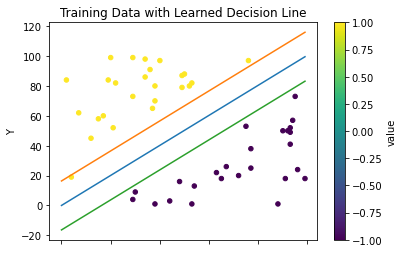

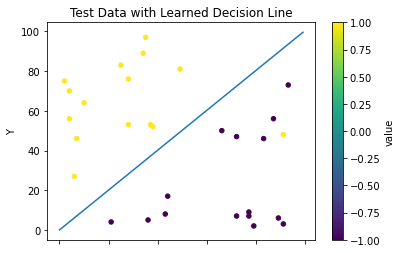

In [13]:
#Variables
steps = 400
learning_rate = 0.0001
C = 1;
w = np.array([0,0,0])

ordered_points, ordered_values = sep_data(order(tr_data_ls))

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(ordered_points, ordered_values, w, steps, learning_rate, C)

plot_data(tr_data_ls, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls), accuracy(w, test_data))

ordering the data does not seem to change to much the lines generated are good and are sometimes better that when the data is not generated.

<h4>Case IV. where w = [0,0,0] step_size = 0.0001, ordered = false, C = 0.1

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 0.1
4. y = (-3.948311046163979e-05 + 0.03254847084049303x)/0.03400374622926199
5. Total times the weights were updated: 399
6. Final missclassification error on training data: 0.0%
   Final missclassification error on test data: 3.3333333333333335%
7. the margin width is: 42.48919553472898


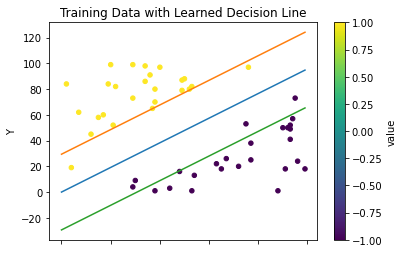

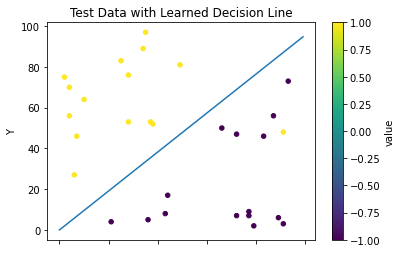

In [14]:
#Variables
steps = 400
learning_rate = 0.0001
C = 0.1;
w = np.array([0,0,0])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points, tr_values, w, steps, learning_rate, C)

plot_data(tr_data_ls, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls), accuracy(w, test_data))

decreasing C too much can cause the margins to get to big which usually leads to a linient classification line. likewise here we see that the line does fit the test data as well

<h2><u>NON-Linearly Separable Data Set</u></h2>

In [15]:
tr_data_ls1 = generate_data(50, linearly_separable=False, min_dist_btwn_points=20)

#seperate data
tr_points1, tr_values1 = sep_data(tr_data_ls1)

<h4>Base case (w = [0,0,0], learning_rate = 1, ordered = false, , C = 0.5

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 0.5
4. y = (-0.0004915362922129496 + 0.025089202810829263x)/0.03474833903569915
5. Total times the weights were updated: 391
6. Final missclassification error on training data: 10.0%
   Final missclassification error on test data: 10.0%
7. the margin width is: 46.66130564347011


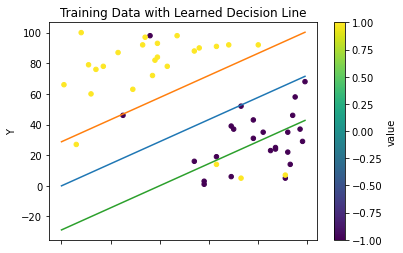

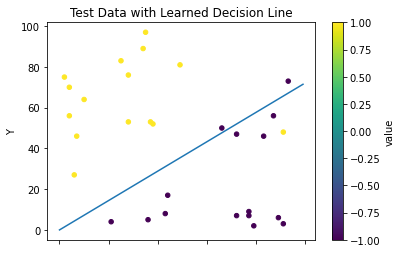

In [16]:
#Variables
steps = 400
learning_rate = 0.0001
C = 0.5;
w = np.array([0,0,0])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points1, tr_values1, w, steps, learning_rate, C)

plot_data(tr_data_ls1, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls1), accuracy(w, test_data))

#save result
base_case1 = w

when the training data is not linearly seperable the lines can change and not fit quite as well but the lines still try to aim for the center of the points much more than a PLA line would

<h4>Case I. where w = [1,1,1] learning_rate = 0.0001, ordered = false, C = 0.5

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 0.5
4. y = (-0.9521131840547513 + -0.2929769561579412x)/0.6821576226338749
5. Total times the weights were updated: 400
6. Final missclassification error on training data: 50.0%
   Final missclassification error on test data: 50.0%
7. the margin width is: 1.656520472081974


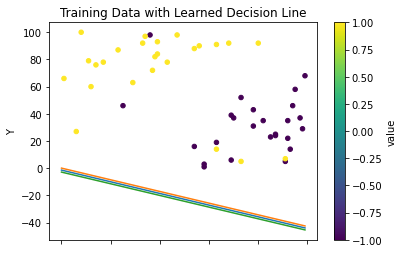

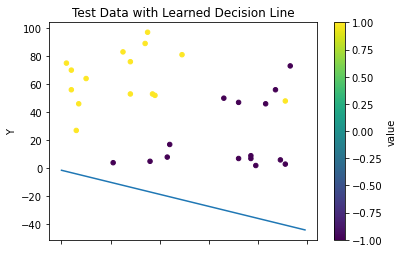

In [17]:
#Variables
steps = 400
learning_rate = 0.0001
C = 0.5;
w = np.array([1,1,1])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points1, tr_values1, w, steps, learning_rate, C)

plot_data(tr_data_ls1, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls1), accuracy(w, test_data))

change of weights have about the same affect here as with training data

<h4>Case II. where w = [0,0,0] learning_rate = 0.1, ordered = false, C = 0.5

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.1 , and C constant: 0.5
4. y = (0.03654812140808561 + 3.463716657337568x)/-0.771964197357718
5. Total times the weights were updated: 39
6. Final missclassification error on training data: 50.0%
   Final missclassification error on test data: 50.0%
7. the margin width is: 0.5635569993406063


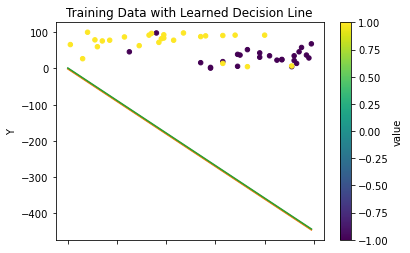

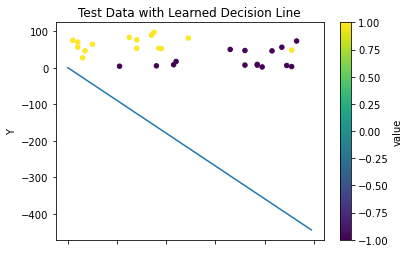

In [18]:
#Variables
steps = 400
learning_rate = 0.1
C = 0.5;
w = np.array([0,0,0])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points1, tr_values1, w, steps, learning_rate, C)

plot_data(tr_data_ls1, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls1), accuracy(w, test_data))

here we can see that the margins become very short and the generated line a very off.

<h4>Case III. where w = [0,0,0] learning_rate = 0.0001, ordered = true, C = 0.5

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 0.5
4. y = (-0.0004911926708933915 + 0.029136536792461927x)/0.030932679896112737
5. Total times the weights were updated: 92
6. Final missclassification error on training data: 10.0%
   Final missclassification error on test data: 3.3333333333333335%
7. the margin width is: 47.0619537314943


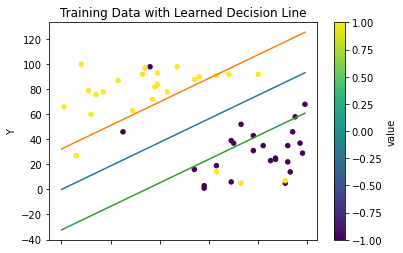

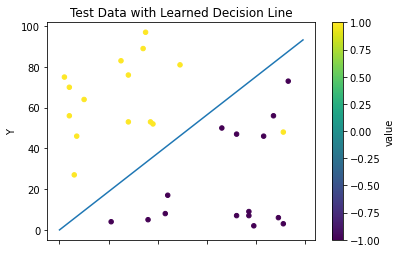

In [19]:
#Variables
steps = 400
learning_rate = 0.0001
C = 0.5;
w = np.array([0,0,0])

ordered_points1, ordered_values1 = sep_data(order(tr_data_ls1))

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(ordered_points1, ordered_values1, w, steps, learning_rate, C)

plot_data(tr_data_ls1, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls1), accuracy(w, test_data))

ordered points seem to be less accurate and generate big margins

<h4>Case IV. where w = [0,0,0] learning_rate = 0.0001, ordered = false, C = 0.05

Note. We generated the points using the python library random.randint() for both x and y coordinates,
   which has a random uniform distribution. We then assigned a value based on the points position relative
   to the y = x line. For non-linearly separable data, we flipped the value 10% of the time.
    (https://docs.python.org/3/library/random.html)
1. Linearly separable training data : True
2. Linearly separable test data: False
3. Initial learning weights: [0, 0, 0] , learing rate: 0.0001 , and C constant: 0.05
4. y = (3.0072350320388207e-05 + 0.02197442302175636x)/0.022085779873799498
5. Total times the weights were updated: 398
6. Final missclassification error on training data: 10.0%
   Final missclassification error on test data: 3.3333333333333335%
7. the margin width is: 64.19436561382086


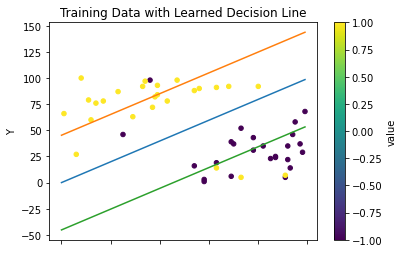

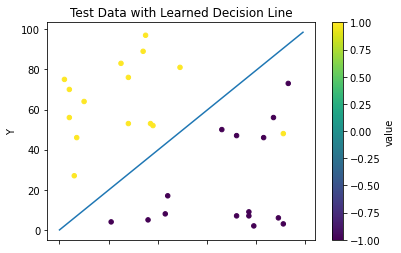

In [20]:
#Variables
steps = 400
learning_rate = 0.0001
C = 0.05;
w = np.array([0,0,0])

#Run SVM Algorithm on training Data
w, updates, iterations, loss_array = svm_sgd(tr_points1, tr_values1, w, steps, learning_rate, C)

plot_data(tr_data_ls1, 'Training Data with Learned Decision Line', w, margins = True)
plot_data(test_data, 'Test Data with Learned Decision Line', w)
print_stats(True, False, [0,0,0], learning_rate, w, C, updates, iterations, accuracy(w, tr_data_ls1), accuracy(w, test_data))

very large margins again which make the decision line very linient allowing many points within the margins